In [1]:
import sys, os, re, gzip, json, pickle, shutil, random
sys.path.append('../app')
from config import Config

from collections import Counter

import numpy as np

from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#from fse.models import SIF
#from fse import IndexedList

from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
config = Config()

In [5]:
class_labels = ['Commercial', 'Fearmonger', 'HashtagGamer', 'LeftTroll', 
                'NewsFeed', 'NormalUser', 'RightTroll', 'Unknown']

with gzip.open(config.feature_x_path, 'rb') as fz:
    feats = pickle.load(fz)

#string labels for all 8 types
type_labels = [feat['type'] for feat in feats]
type_lab2idx = {c:i for i,c in enumerate(class_labels)}

#string binary labels
bin_labels = [l if l=='NormalUser' else 'TrollUser' for l in type_labels]
bin_lab2idx = {'NormalUser':0, 'TrollUser':1}

with gzip.open(config.feature_y_path, 'rb') as fz:
    #int binary labels
    bin_y = pickle.load(fz)
    
#int labels for all 8 types
type_y = [type_lab2idx[l] for l in type_labels]     

len(feats), len(bin_y)

(1000000, 1000000)

In [6]:
#a subset of data consisting of only NormalUser, LeftTroll, RightTroll
three_class_lab2int = {'LeftTroll':0, 'NormalUser':1, 'RightTroll':2}

three_class_feats = [f for f in feats if f['type'] in three_class_lab2int]
three_class_labels = [f['type'] for f in three_class_feats]
three_class_y = [three_class_lab2int[l] for l in three_class_labels]

len(three_class_feats), len(three_class_labels), len(three_class_y)

(765127, 765127, 765127)

In [7]:
#lemmas = [f['lemmas'].strip() for f in feats]
tokens = [f['tokens'].strip() for f in feats]

In [7]:
def train_w2v(texts, model_path, vec_dim=128, window=5):
    model = Word2Vec(sentences=texts, size=vec_dim, window=window, min_count=10, workers=4)
    model.train(texts, total_examples=len(texts), epochs=5)

    print('...Storing trained word2vec model')
    model.save(model_path)
    
    for word in ['one', 'cat', 'fun', 'stupid', 'lol']:
        print('close to %s' % word)
        for w,s in model.wv.most_similar(word):
            print('   %s, %.6f' % (w,s))
            
    return model


def train_ft(texts, model_path, vec_dim=128, window=5):
    model = FastText(sentences=texts, size=vec_dim, window=window, min_count=10, workers=4)
    model.train(texts, total_examples=len(texts), epochs=5)

    print('...Storing trained fasttext model')
    model.save(model_path)
    
    for word in ['one', 'cat', 'fun', 'stupid', 'lol']:
        print('close to %s' % word)
        for w,s in model.wv.most_similar(word):
            print('   %s, %.6f' % (w,s))
            
    return model

In [8]:
token_texts = [[t for t in l.split(' ') if t and not t[0]=='#'] for l in tokens]

In [9]:
word_vec_dim = 128
if os.path.exists('w2v_token_%d.model' % word_vec_dim):
    w2v_token_128_model = Word2Vec.load('w2v_token_%d.model' % word_vec_dim)
else:
    w2v_token_128_model = train_w2v(token_texts, model_path='w2v_token_%d.model' % word_vec_dim, 
                                vec_dim=word_vec_dim, window=5)

In [10]:
if os.path.exists('ft_token_%d.model' % word_vec_dim):
    ft_token_128_model = FastText.load('ft_token_%d.model' % word_vec_dim)
else:
    ft_token_128_model = train_ft(token_texts, model_path='ft_token_%d.model' % word_vec_dim, 
                              vec_dim=word_vec_dim, window=5)

In [11]:
class LinearClassifier(nn.Module):
    def __init__(self, hid1_size, hid2_size, out_size, text_vocab_size, text_emb_dim, 
                 pos_vocab_size, pos_emb_dim, ent_vocab_size, ent_emb_dim, 
                 hashtag_vocab_size, hashtag_emb_dim, in_feat_dim, out_feat_dim, ablation_fields=[]):
        super().__init__()
        self.ablation_fields = ablation_fields
        concat_dim = 0
        
        if 'text' not in self.ablation_fields:
            self.text_embedder = nn.EmbeddingBag(text_vocab_size, text_emb_dim)
            concat_dim += text_emb_dim
        if 'pos' not in self.ablation_fields:
            self.pos_embedder = nn.EmbeddingBag(pos_vocab_size, pos_emb_dim)
            concat_dim += pos_emb_dim
        if 'ent' not in self.ablation_fields:
            self.ent_embedder = nn.EmbeddingBag(ent_vocab_size, ent_emb_dim)
            concat_dim += ent_emb_dim
        if 'hashtag' not in self.ablation_fields:
            self.hashtag_embedder = nn.EmbeddingBag(hashtag_vocab_size, hashtag_emb_dim)
            concat_dim += hashtag_emb_dim
        if 'feats' not in self.ablation_fields:
            self.feat_transform = nn.Linear(in_feat_dim, out_feat_dim)
            concat_dim += out_feat_dim
        
        self.hid_layer1 = nn.Linear(concat_dim, hid1_size)
        self.hid_layer2 = nn.Linear(hid1_size, hid2_size)
        self.out_layer = nn.Linear(hid2_size, out_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(hid1_size)
        self.batchnorm2 = nn.BatchNorm1d(hid2_size)
        
        
    def forward(self, x_text, x_pos, x_ent, x_hashtag, x_feats):
        embs = []
        
        if 'text' not in self.ablation_fields:
            text_emb = self.text_embedder(x_text)
            embs.append(text_emb)
        if 'pos' not in self.ablation_fields:
            pos_emb = self.pos_embedder(x_pos)
            embs.append(pos_emb)
        if 'ent' not in self.ablation_fields:
            ent_emb = self.ent_embedder(x_ent)
            embs.append(ent_emb)
        if 'hashtag' not in self.ablation_fields:
            hashtag_emb = self.hashtag_embedder(x_hashtag)
            embs.append(hashtag_emb)
        if 'feats' not in self.ablation_fields:
            feat_trans = self.feat_transform(x_feats)
            embs.append(feat_trans)
        
        x = torch.cat(embs, dim=1)
        x = self.dropout(x)
        
        x = self.relu(self.hid_layer1(x))
        x = self.batchnorm1(x)
        
        x = self.relu(self.hid_layer2(x))
        x = self.batchnorm2(x)
        
        x = self.out_layer(x)
        
        return F.log_softmax(x, dim=1)

In [12]:
def get_feature2idx_dicts(feats, word_model):
    word2idx = {}
    for i in range(len(word_model.wv.vocab)):
        word2idx[word_model.wv.index2word[i]] = i

    pos2idx = {}
    i=1
    for feat in feats:
        for pos in feat['pos'].split(' '):
            if not pos:
                continue
            if pos not in pos2idx:
                pos2idx[pos] = i
                i+=1
    pos2idx['<PAD>'] = 0

    ent2idx = {}
    i=1
    for feat in feats:
        for et in feat['ent_types']:
            #skip some bogus entity types
            if not et or not et.isupper():
                continue
            if et not in ent2idx:
                ent2idx[et] = i
                i+=1
    ent2idx['<PAD>'] = 0

    #only use hashtags with over 10 occurrences
    hashtags = []
    for feat in feats:
        hashtags.extend(feat['hashtags'])

    hashtag_cts = Counter(hashtags)
    hashtag_cts = {h:c for h,c in hashtag_cts.items() if c>=10}

    hashtag2idx = {h:i+1 for i,h in enumerate(hashtag_cts.keys())}
    hashtag2idx['<PAD>'] = 0

    feat_fields = ['emoji_ratio', 'link_ratio', 'user_ratio', 'oov_ratio']
    
    return word2idx, pos2idx, ent2idx, hashtag2idx, feat_fields

In [13]:
word2idx, pos2idx, ent2idx, hashtag2idx, feat_fields = get_feature2idx_dicts(feats, w2v_token_128_model)

In [14]:
def get_tensors(feats, word2idx, pos2idx, ent2idx, hashtag2idx, feat_fields, lab2idx,
               text_seq_len = 30, ent_seq_len = 2, hashtag_seq_len = 2, 
                use_lemmas=False, reload=False):
    if reload and os.path.exists('y_type_%d.pt' % len(lab2idx)):
        x_text = torch.load('x_text.pt')
        x_pos = torch.load('x_pos.pt')
        x_ent = torch.load('x_ent.pt')
        x_hashtag = torch.load('x_hashtag.pt')
        x_feats = torch.load('x_feats.pt')
        y_bin = torch.load('y_bin.pt')
        y_type = torch.load('y_type_%d.pt' % len(lab2idx))
        
        return x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, y_type
    
    x_text = []
    x_pos = []
    x_ent = []
    x_hashtag = []
    x_feats = []
    y_bin = []
    y_type = []
    
    for feat in feats:
        #if feat['type'] not in lab2idx:
        #    continue

        if use_lemmas:
            #we use the actual word 'pad' as the pad token bc the pretrained wts must be the same size as the vocab
            s = [word2idx[t] for t in feat['lemmas'].split(' ') if t and t in word2idx] + [word2idx['pad']]*text_seq_len
        else:
            s = [word2idx[t] for t in feat['tokens'].split(' ') if t and t in word2idx] + [word2idx['pad']]*text_seq_len
        x_text.append(torch.tensor(s[:text_seq_len]))

        s = [pos2idx[t] for t in feat['pos'].split(' ') if t and t in pos2idx] + [pos2idx['<PAD>']]*text_seq_len
        x_pos.append(torch.tensor(s[:text_seq_len]))

        s = [ent2idx[t] for t in feat['ent_types'] if t and t in ent2idx] + [ent2idx['<PAD>']]*ent_seq_len
        x_ent.append(torch.tensor(s[:ent_seq_len]))

        s = [hashtag2idx[t] for t in feat['hashtags'] if t and t in hashtag2idx] + [hashtag2idx['<PAD>']]*hashtag_seq_len
        x_hashtag.append(torch.tensor(s[:hashtag_seq_len]))

        x_feats.append(torch.tensor([feat[f] for f in feat_fields]))

        y_bin.append(0 if feat['type']=='NormalUser' else 1)
        y_type.append(lab2idx[feat['type']])

    x_text = torch.vstack(x_text)
    x_pos = torch.vstack(x_pos)
    x_ent = torch.vstack(x_ent)
    x_hashtag = torch.vstack(x_hashtag)
    x_feats = torch.vstack(x_feats)
    y_bin = torch.tensor(y_bin)
    y_type = torch.tensor(y_type)

    torch.save(x_text, 'x_text.pt')
    torch.save(x_pos, 'x_pos.pt')
    torch.save(x_ent, 'x_ent.pt')
    torch.save(x_hashtag, 'x_hashtag.pt')
    torch.save(x_feats, 'x_feats.pt')
    torch.save(y_bin, 'y_bin.pt')
    torch.save(y_type, 'y_type_%d.pt' % len(lab2idx))
    
    return x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, y_type

In [15]:
x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, y_type = get_tensors(feats, word2idx, pos2idx, ent2idx, hashtag2idx, 
                                        feat_fields, type_lab2idx, use_lemmas=False, reload=False)
x_text.size(), x_pos.size(), x_ent.size(), x_hashtag.size(), x_feats.size(), y_bin.size(), x_text[0]

(torch.Size([1000000, 30]),
 torch.Size([1000000, 30]),
 torch.Size([1000000, 2]),
 torch.Size([1000000, 2]),
 torch.Size([1000000, 4]),
 torch.Size([1000000]),
 tensor([   22,     7,     2,   233,     5,   111, 24489,   109,     5,   201,
         24489,    36,   494,   797,     0, 12496, 12496, 12496, 12496, 12496,
         12496, 12496, 12496, 12496, 12496, 12496, 12496, 12496, 12496, 12496]))

In [16]:
Counter(y_bin.tolist())

Counter({0: 500000, 1: 500000})

In [39]:
def train_model(x_text, x_pos, x_ent, x_hashtag, x_feats, y, class_labels, model, 
                optimizer, scheduler, batch_size, epochs, device, test_size=10000, model_name='lin_model_bin.pt'):
    print(model)
    x_text_test = x_text[:test_size]
    x_text_cv = x_text[test_size:2*test_size]
    x_text_train = x_text[2*test_size:]

    x_pos_test = x_pos[:test_size]
    x_pos_cv = x_pos[test_size:2*test_size]
    x_pos_train = x_pos[2*test_size:]

    x_ent_test = x_ent[:test_size]
    x_ent_cv = x_ent[test_size:2*test_size]
    x_ent_train = x_ent[2*test_size:]

    x_hashtag_test = x_hashtag[:test_size]
    x_hashtag_cv = x_hashtag[test_size:2*test_size]
    x_hashtag_train = x_hashtag[2*test_size:]

    x_feats_test = x_feats[:test_size]
    x_feats_cv = x_feats[test_size:2*test_size]
    x_feats_train = x_feats[2*test_size:]

    y_test = y[:test_size]
    y_cv = y[test_size:2*test_size]
    y_train = y[2*test_size:]
    
    x_text_train_batches = [x_text_train[i*batch_size:(i+1)*batch_size] for i in range((x_text_train.shape[0]//batch_size) + 1)]
    x_pos_train_batches = [x_pos_train[i*batch_size:(i+1)*batch_size] for i in range((x_pos_train.shape[0]//batch_size) + 1)]
    x_ent_train_batches = [x_ent_train[i*batch_size:(i+1)*batch_size] for i in range((x_ent_train.shape[0]//batch_size) + 1)]
    x_hashtag_train_batches = [x_hashtag_train[i*batch_size:(i+1)*batch_size] for i in range((x_hashtag_train.shape[0]//batch_size) + 1)]
    x_feats_train_batches = [x_feats_train[i*batch_size:(i+1)*batch_size] for i in range((x_feats_train.shape[0]//batch_size) + 1)]
    y_train_batches = [y_train[i*batch_size:(i+1)*batch_size] for i in range((y_train.shape[0]//batch_size) + 1)]
    
    best_cv_acc = 0
    losses = []
    no_improvement = 0
    
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        
        idx = list(range(len(x_text_train_batches)))
        #random.shuffle(idx)
        #x_batches = [x_batches[i] for i in idx]
        #y_batches = [y_batches[i] for i in idx]
        
        for i in range(len(x_text_train_batches)):
            optimizer.zero_grad()

            y_pred = model(x_text_train_batches[i].to(device),
                           x_pos_train_batches[i].to(device), 
                           x_ent_train_batches[i].to(device),
                           x_hashtag_train_batches[i].to(device), 
                           x_feats_train_batches[i].to(device))

            loss = F.nll_loss(y_pred, y_train_batches[i])
            acc = binary_acc(y_pred, y_train_batches[i].float())#.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            if i and i%1000==0:
                print('  ...Batch %d\tEpoch %d\tLoss: %.8f\tTrain Acc: %.8f' % (
                    i, epoch, epoch_loss/i, epoch_acc/i))
                losses.append(epoch_loss/i)
        
        cv_acc = test(x_text_cv, x_pos_cv, x_ent_cv, x_hashtag_cv, x_feats_cv, y_cv, 
                      model, class_labels)
        if cv_acc>best_cv_acc:
            print('\n *** CV Accuracy Improved: %.4f -> %.4f ***' % (best_cv_acc, cv_acc))
            torch.save(model.state_dict(), model_name)
            best_cv_acc=cv_acc
            no_improvement = 0
        else:
            no_improvement += 1
        
        if no_improvement >= 5:
            break
            
        scheduler.step(cv_acc)
            
        print('\nEpoch %d\tLoss: %.8f\tTrain Acc: %.8f\tCV Acc: %.8f\tNo Improvement: %d' % (
            epoch, epoch_loss/len(x_text_train_batches), epoch_acc/len(x_text_train_batches), cv_acc, no_improvement))
        
    test_acc = test(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test, y_test, 
                    model, class_labels, print_confusion=True)
    print('\n\n\nFinal Test Acc: %.8f' % (test_acc))
        
    return model, losses
        
        
def binary_acc(y_pred, y_test):
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    cor = (y_pred == y_test).int().sum()
    acc = cor/y_test.size()[0]
    
    return acc


def test(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test, y_test, 
         model, class_labels, print_confusion=False):
    model.eval()
    
    with torch.no_grad():
        y_pred = model(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test)
        y_pred = torch.argmax(y_pred, dim=1).cpu()
    
    print('\n\n')
    print(classification_report(y_test.tolist(), y_pred.tolist(), target_names=class_labels, digits=4))
    print('\n\n')
    
    if print_confusion:
        cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
        f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

    cor = (y_pred == y_test).int().sum()
    acc = cor/y_test.size()[0]
    
    model.train()
    
    return acc

In [42]:
# 2 class instance, using word2vec embeddings

lin_model = LinearClassifier(hid1_size=512, hid2_size=128, out_size=2, 
                             text_vocab_size=len(word2idx), text_emb_dim=word_vec_dim, 
                             pos_vocab_size=len(pos2idx), pos_emb_dim=8,
                             ent_vocab_size=len(ent2idx), ent_emb_dim=8, 
                             hashtag_vocab_size=len(hashtag2idx), hashtag_emb_dim=64, 
                             in_feat_dim=len(feat_fields), out_feat_dim=len(feat_fields))

#copy pretrained word weights
lin_model.text_embedder.weight.data.copy_(torch.FloatTensor(w2v_token_128_model.wv.vectors))
#lin_model.text_embedder.weight.requires_grad = False

tensor([[-0.5828, -0.1913, -0.5416,  ..., -0.6504,  0.8422, -1.2246],
        [ 1.5625,  1.6683,  1.1405,  ...,  1.2371, -0.1109,  0.2551],
        [ 1.3750,  0.9242, -0.5991,  ...,  0.4427,  0.4270,  1.0353],
        ...,
        [ 0.1085, -0.1361, -0.1510,  ..., -0.2159,  0.0067, -0.0874],
        [-0.0861,  0.0119, -0.0292,  ..., -0.0984,  0.1513,  0.0046],
        [ 0.2633,  0.1682, -0.3559,  ..., -0.4158, -0.0575,  0.0583]])

In [43]:
lr = 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lin_model.to(device)
lin_model.train()

optimizer = optim.Adam(lin_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4)

cpu


  ...Batch 1000	Epoch 1	Loss: 0.21350766	Train Acc: 0.91270312
  ...Batch 2000	Epoch 1	Loss: 0.16862020	Train Acc: 0.93171875
  ...Batch 3000	Epoch 1	Loss: 0.14653585	Train Acc: 0.94063021
  ...Batch 4000	Epoch 1	Loss: 0.13249760	Train Acc: 0.94639648
  ...Batch 5000	Epoch 1	Loss: 0.12264296	Train Acc: 0.95043438
  ...Batch 6000	Epoch 1	Loss: 0.11498404	Train Acc: 0.95361198
  ...Batch 7000	Epoch 1	Loss: 0.10902813	Train Acc: 0.95597433



              precision    recall  f1-score   support

  NormalUser     0.9674    0.9865    0.9768      5025
   TrollUser     0.9861    0.9664    0.9761      4975

    accuracy                         0.9765     10000
   macro avg     0.9767    0.9764    0.9765     10000
weighted avg     0.9767    0.9765    0.9765     10000





 *** CV Accuracy Improved: 0.0000 -> 0.9765 ***

Epoch 1	Loss: 0.10587170	Train Acc: 0.95711951	CV Acc: 0.97649997	No Improvement: 0
  ...Batch 1000	Epoch 2	Loss: 0.06564424	Train Acc: 0.97422656
  ...Batch 2000	Epoch 2	Loss:

  ...Batch 4000	Epoch 10	Loss: 0.03084052	Train Acc: 0.98778906
  ...Batch 5000	Epoch 10	Loss: 0.03055604	Train Acc: 0.98793750
  ...Batch 6000	Epoch 10	Loss: 0.03020398	Train Acc: 0.98809375
  ...Batch 7000	Epoch 10	Loss: 0.02980291	Train Acc: 0.98820536



              precision    recall  f1-score   support

  NormalUser     0.9753    0.9881    0.9816      5025
   TrollUser     0.9878    0.9747    0.9812      4975

    accuracy                         0.9814     10000
   macro avg     0.9815    0.9814    0.9814     10000
weighted avg     0.9815    0.9814    0.9814     10000





Epoch 10	Loss: 0.02963515	Train Acc: 0.98816442	CV Acc: 0.98140001	No Improvement: 3
  ...Batch 1000	Epoch 11	Loss: 0.02967092	Train Acc: 0.98935156
  ...Batch 2000	Epoch 11	Loss: 0.03039147	Train Acc: 0.98847656
  ...Batch 3000	Epoch 11	Loss: 0.03029736	Train Acc: 0.98829427
  ...Batch 4000	Epoch 11	Loss: 0.03019950	Train Acc: 0.98818750
  ...Batch 5000	Epoch 11	Loss: 0.02993397	Train Acc: 0.98825625
  ...

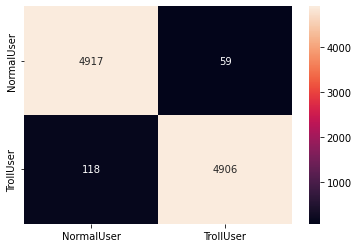

In [44]:
batch_size = 128
epochs = 100
class_labels = ['NormalUser', 'TrollUser']
lin_model, losses = train_model(x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, class_labels, lin_model, 
                optimizer, scheduler, batch_size, epochs, device)
#5 classes 0.9113
#bin 0.9818

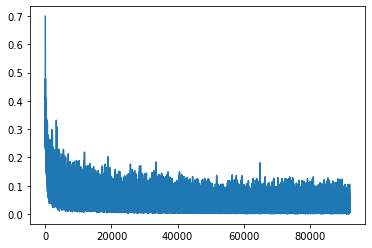

In [45]:
plt.plot(losses)
plt.show()

In [47]:
lin_model.load_state_dict(torch.load("lin_model_bin.pt"))
lin_model.eval()

LinearClassifier(
  (text_embedder): EmbeddingBag(47879, 128, mode=mean)
  (pos_embedder): EmbeddingBag(52, 8, mode=mean)
  (ent_embedder): EmbeddingBag(19, 8, mode=mean)
  (hashtag_embedder): EmbeddingBag(3934, 64, mode=mean)
  (feat_transform): Linear(in_features=4, out_features=4, bias=True)
  (hid_layer1): Linear(in_features=212, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)




              precision    recall  f1-score   support

  NormalUser     0.9747    0.9891    0.9818      4976
   TrollUser     0.9891    0.9745    0.9818      5024

    accuracy                         0.9818     10000
   macro avg     0.9819    0.9818    0.9818     10000
weighted avg     0.9819    0.9818    0.9818     10000







Final Test Acc: 0.98180002


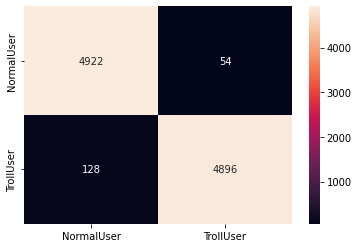

In [48]:
test_acc = test(x_text[:10000], x_pos[:10000], x_ent[:10000], x_hashtag[:10000], x_feats[:10000], y_bin[:10000], 
                lin_model, class_labels, print_confusion=True)

print('\n\n\nFinal Test Acc: %.8f' % (test_acc))

# Ablation studies

In [60]:
def run_ablation_study(ablation_fields, word_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, 
                       init_with_word_vecs=True):
    model_name = 'lin_model_bin_ablation-%s.pt' % ','.join(ablation_fields)
    
    lin_model_ablation = LinearClassifier(hid1_size=512, hid2_size=128, out_size=2, 
                                 text_vocab_size=len(word2idx), text_emb_dim=word_vec_dim, 
                                 pos_vocab_size=len(pos2idx), pos_emb_dim=8,
                                 ent_vocab_size=len(ent2idx), ent_emb_dim=8, 
                                 hashtag_vocab_size=len(hashtag2idx), hashtag_emb_dim=64, 
                                 in_feat_dim=len(feat_fields), out_feat_dim=len(feat_fields),
                                ablation_fields=ablation_fields)
    
    if not 'text' in ablation_fields and init_with_word_vecs:
        #copy pretrained word weights
        lin_model_ablation.text_embedder.weight.data.copy_(torch.FloatTensor(word_model.wv.vectors))
        
    lr = 1e-3
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    lin_model_ablation.to(device)
    lin_model_ablation.train()

    optimizer = optim.Adam(lin_model_ablation.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4)
    
    batch_size = 128
    epochs = 3
    class_labels = ['NormalUser', 'TrollUser']
    lin_model_ablation, losses = train_model(x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, 
                                             class_labels, lin_model_ablation, optimizer, scheduler, 
                                             batch_size, epochs, device, model_name=model_name)
    
    return model_name, lin_model_ablation, losses

## Remove Text

  ...Batch 1000	Epoch 1	Loss: 0.32986283	Train Acc: 0.84803906
  ...Batch 2000	Epoch 1	Loss: 0.25547008	Train Acc: 0.88676953
  ...Batch 3000	Epoch 1	Loss: 0.22065361	Train Acc: 0.90365365
  ...Batch 4000	Epoch 1	Loss: 0.19889546	Train Acc: 0.91392969
  ...Batch 5000	Epoch 1	Loss: 0.18432147	Train Acc: 0.92085000
  ...Batch 6000	Epoch 1	Loss: 0.17330809	Train Acc: 0.92590234
  ...Batch 7000	Epoch 1	Loss: 0.16484782	Train Acc: 0.92963951



              precision    recall  f1-score   support

  NormalUser     0.9266    0.9950    0.9596      5025
   TrollUser     0.9946    0.9204    0.9560      4975

    accuracy                         0.9579     10000
   macro avg     0.9606    0.9577    0.9578     10000
weighted avg     0.9604    0.9579    0.9578     10000





 *** CV Accuracy Improved: 0.0000 -> 0.9579 ***

Epoch 1	Loss: 0.16037715	Train Acc: 0.93149855	CV Acc: 0.95789999	No Improvement: 0
  ...Batch 1000	Epoch 2	Loss: 0.10863468	Train Acc: 0.95498437
  ...Batch 2000	Epoch 2	Loss:

  ...Batch 5000	Epoch 10	Loss: 0.08745567	Train Acc: 0.96203750
  ...Batch 6000	Epoch 10	Loss: 0.08736942	Train Acc: 0.96214453
  ...Batch 7000	Epoch 10	Loss: 0.08726635	Train Acc: 0.96218192



              precision    recall  f1-score   support

  NormalUser     0.9368    0.9938    0.9645      5025
   TrollUser     0.9934    0.9323    0.9618      4975

    accuracy                         0.9632     10000
   macro avg     0.9651    0.9630    0.9632     10000
weighted avg     0.9649    0.9632    0.9632     10000







              precision    recall  f1-score   support

  NormalUser     0.9356    0.9928    0.9633      4976
   TrollUser     0.9924    0.9323    0.9614      5024

    accuracy                         0.9624     10000
   macro avg     0.9640    0.9625    0.9624     10000
weighted avg     0.9641    0.9624    0.9624     10000







Final Test Acc: 0.96240002


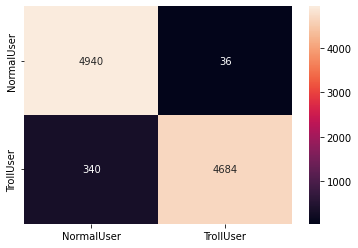

In [38]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['text'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.9624!!!

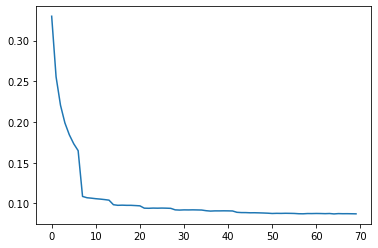

In [40]:
plt.plot(losses)
plt.show()




              precision    recall  f1-score   support

  NormalUser     0.9376    0.9930    0.9645      4976
   TrollUser     0.9926    0.9345    0.9627      5024

    accuracy                         0.9636     10000
   macro avg     0.9651    0.9637    0.9636     10000
weighted avg     0.9652    0.9636    0.9636     10000







Final Test Acc: 0.96359998


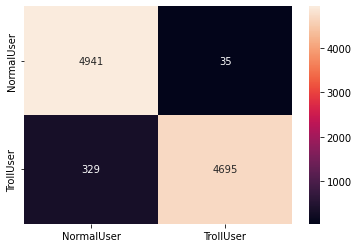

In [41]:
lin_model_ablation.load_state_dict(torch.load(model_name))
lin_model.eval()
class_labels = ['NormalUser', 'TrollUser']
test_acc = test(x_text[:10000], x_pos[:10000], x_ent[:10000], x_hashtag[:10000], x_feats[:10000], y_bin[:10000], 
                lin_model_ablation, class_labels, print_confusion=True)

print('\n\n\nFinal Test Acc: %.8f' % (test_acc))
#0.9636

## Remove POS

LinearClassifier(
  (text_embedder): EmbeddingBag(47879, 128, mode=mean)
  (ent_embedder): EmbeddingBag(19, 8, mode=mean)
  (hashtag_embedder): EmbeddingBag(3934, 64, mode=mean)
  (feat_transform): Linear(in_features=4, out_features=4, bias=True)
  (hid_layer1): Linear(in_features=204, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.30742131	Train Acc: 0.86957031
  ...Batch 2000	Epoch 1	Loss: 0.28016899	Train Acc: 0.88250781
  ...Batch 3000	Epoch 1	Loss: 0.26289443	Train Acc: 0.89045052
  ...Batch 4000	Epoch 1	Loss: 0.24918067	Train Acc: 0.89673047
  ...Batch 5000	Epoch 1	Loss: 0.23896391	

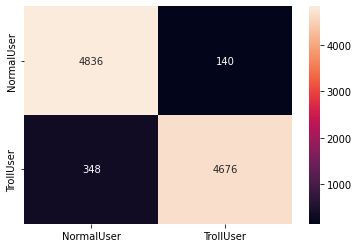

In [54]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['pos'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.9512

## Remove Entities

LinearClassifier(
  (text_embedder): EmbeddingBag(47879, 128, mode=mean)
  (pos_embedder): EmbeddingBag(52, 8, mode=mean)
  (hashtag_embedder): EmbeddingBag(3934, 64, mode=mean)
  (feat_transform): Linear(in_features=4, out_features=4, bias=True)
  (hid_layer1): Linear(in_features=204, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.21870041	Train Acc: 0.91127344
  ...Batch 2000	Epoch 1	Loss: 0.17175347	Train Acc: 0.93082031
  ...Batch 3000	Epoch 1	Loss: 0.14837972	Train Acc: 0.94029688
  ...Batch 4000	Epoch 1	Loss: 0.13344130	Train Acc: 0.94625391
  ...Batch 5000	Epoch 1	Loss: 0.12311627	

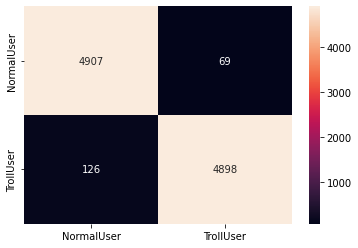

In [55]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['ent'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.9805

## Remove Hashtags

LinearClassifier(
  (text_embedder): EmbeddingBag(47879, 128, mode=mean)
  (pos_embedder): EmbeddingBag(52, 8, mode=mean)
  (ent_embedder): EmbeddingBag(19, 8, mode=mean)
  (feat_transform): Linear(in_features=4, out_features=4, bias=True)
  (hid_layer1): Linear(in_features=148, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.22687409	Train Acc: 0.90217969
  ...Batch 2000	Epoch 1	Loss: 0.18273560	Train Acc: 0.92162500
  ...Batch 3000	Epoch 1	Loss: 0.16212462	Train Acc: 0.93057552
  ...Batch 4000	Epoch 1	Loss: 0.14909946	Train Acc: 0.93610547
  ...Batch 5000	Epoch 1	Loss: 0.13978546	Train A

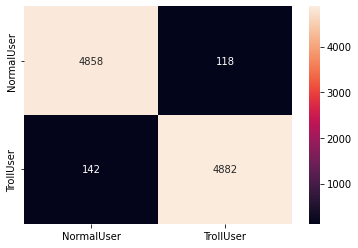

In [56]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['hashtag'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.9740

In [ ]:
#Dad's grounded ha ha  soren was here

## Remove feats

LinearClassifier(
  (text_embedder): EmbeddingBag(47879, 128, mode=mean)
  (pos_embedder): EmbeddingBag(52, 8, mode=mean)
  (ent_embedder): EmbeddingBag(19, 8, mode=mean)
  (hashtag_embedder): EmbeddingBag(3934, 64, mode=mean)
  (hid_layer1): Linear(in_features=208, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.26148429	Train Acc: 0.89060938
  ...Batch 2000	Epoch 1	Loss: 0.20230843	Train Acc: 0.91683594
  ...Batch 3000	Epoch 1	Loss: 0.17181868	Train Acc: 0.92996615
  ...Batch 4000	Epoch 1	Loss: 0.15263728	Train Acc: 0.93801953
  ...Batch 5000	Epoch 1	Loss: 0.13937256	Train Acc: 0.9434859

  ...Batch 7000	Epoch 9	Loss: 0.03095460	Train Acc: 0.98770313



              precision    recall  f1-score   support

  NormalUser     0.9751    0.9897    0.9823      5025
   TrollUser     0.9894    0.9745    0.9819      4975

    accuracy                         0.9821     10000
   macro avg     0.9822    0.9821    0.9821     10000
weighted avg     0.9822    0.9821    0.9821     10000





 *** CV Accuracy Improved: 0.9820 -> 0.9821 ***

Epoch 9	Loss: 0.03087163	Train Acc: 0.98761754	CV Acc: 0.98210001	No Improvement: 0
  ...Batch 1000	Epoch 10	Loss: 0.03073492	Train Acc: 0.98872656
  ...Batch 2000	Epoch 10	Loss: 0.03172386	Train Acc: 0.98782812
  ...Batch 3000	Epoch 10	Loss: 0.03149216	Train Acc: 0.98760938
  ...Batch 4000	Epoch 10	Loss: 0.03133975	Train Acc: 0.98758789
  ...Batch 5000	Epoch 10	Loss: 0.03112599	Train Acc: 0.98763281
  ...Batch 6000	Epoch 10	Loss: 0.03077034	Train Acc: 0.98775521
  ...Batch 7000	Epoch 10	Loss: 0.03037221	Train Acc: 0.98787946



              preci

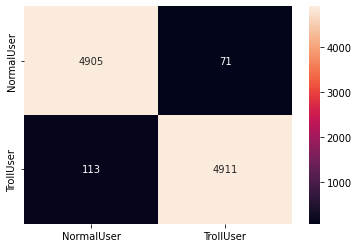

In [42]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['feats'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.9815

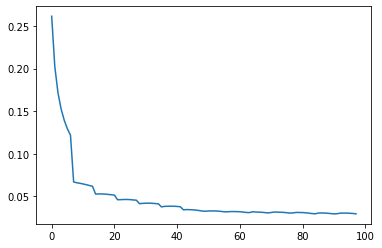

In [43]:
plt.plot(losses)
plt.show()




              precision    recall  f1-score   support

  NormalUser     0.9760    0.9871    0.9815      4976
   TrollUser     0.9871    0.9759    0.9815      5024

    accuracy                         0.9815     10000
   macro avg     0.9815    0.9815    0.9815     10000
weighted avg     0.9816    0.9815    0.9815     10000







Final Test Acc: 0.98150003


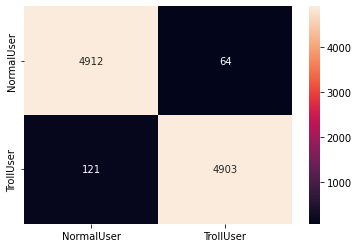

In [46]:
lin_model_ablation.load_state_dict(torch.load(model_name))
lin_model.eval()
class_labels = ['NormalUser', 'TrollUser']
test_acc = test(x_text[:10000], x_pos[:10000], x_ent[:10000], x_hashtag[:10000], x_feats[:10000], y_bin[:10000], 
                lin_model_ablation, class_labels, print_confusion=True)

print('\n\n\nFinal Test Acc: %.8f' % (test_acc))
#0.9815

## Only text

LinearClassifier(
  (text_embedder): EmbeddingBag(47879, 128, mode=mean)
  (hid_layer1): Linear(in_features=128, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.35691234	Train Acc: 0.84189063
  ...Batch 2000	Epoch 1	Loss: 0.33173414	Train Acc: 0.85401172
  ...Batch 3000	Epoch 1	Loss: 0.31500031	Train Acc: 0.86165104
  ...Batch 4000	Epoch 1	Loss: 0.30230108	Train Acc: 0.86776758
  ...Batch 5000	Epoch 1	Loss: 0.29334454	Train Acc: 0.87208750
  ...Batch 6000	Epoch 1	Loss: 0.28571694	Train Acc: 0.87563411
  ...Batch 7000	Epoch 1	Loss: 0.27966994	Train Acc: 0.87853683



              precision

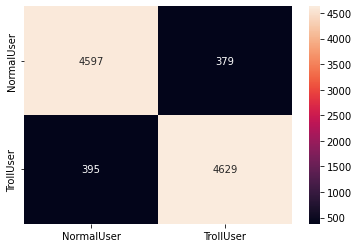

In [53]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['pos', 'ent', 'hashtag', 'feats'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.9225

## Only Text - No Word2Vec Initialization

LinearClassifier(
  (text_embedder): EmbeddingBag(47879, 128, mode=mean)
  (hid_layer1): Linear(in_features=128, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.48754532	Train Acc: 0.76096094
  ...Batch 2000	Epoch 1	Loss: 0.42491987	Train Acc: 0.79816406
  ...Batch 3000	Epoch 1	Loss: 0.39035787	Train Acc: 0.81783333
  ...Batch 4000	Epoch 1	Loss: 0.36706648	Train Acc: 0.83083203
  ...Batch 5000	Epoch 1	Loss: 0.35035728	Train Acc: 0.83995625
  ...Batch 6000	Epoch 1	Loss: 0.33720575	Train Acc: 0.84693750
  ...Batch 7000	Epoch 1	Loss: 0.32667540	Train Acc: 0.85259487



              precision

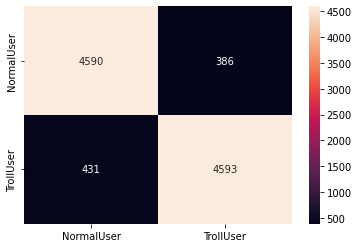

In [62]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['pos', 'ent', 'hashtag', 'feats'], w2v_token_128_model, 
    x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, init_with_word_vecs=False)
#0.9182

## Only POS

LinearClassifier(
  (pos_embedder): EmbeddingBag(52, 8, mode=mean)
  (hid_layer1): Linear(in_features=8, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.40382230	Train Acc: 0.80789062
  ...Batch 2000	Epoch 1	Loss: 0.32887047	Train Acc: 0.84831641
  ...Batch 3000	Epoch 1	Loss: 0.29191962	Train Acc: 0.86795833
  ...Batch 4000	Epoch 1	Loss: 0.26865062	Train Acc: 0.87965234
  ...Batch 5000	Epoch 1	Loss: 0.25328289	Train Acc: 0.88755156
  ...Batch 6000	Epoch 1	Loss: 0.24173796	Train Acc: 0.89331771
  ...Batch 7000	Epoch 1	Loss: 0.23237647	Train Acc: 0.89777232



              precision    reca

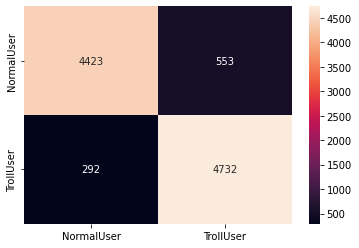

In [49]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['text', 'ent', 'hashtag', 'feats'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.915

## Only Entities

LinearClassifier(
  (ent_embedder): EmbeddingBag(19, 8, mode=mean)
  (hid_layer1): Linear(in_features=8, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.65333918	Train Acc: 0.61381250
  ...Batch 2000	Epoch 1	Loss: 0.64905634	Train Acc: 0.61780469
  ...Batch 3000	Epoch 1	Loss: 0.64758101	Train Acc: 0.61864583
  ...Batch 4000	Epoch 1	Loss: 0.64603552	Train Acc: 0.62030664
  ...Batch 5000	Epoch 1	Loss: 0.64478596	Train Acc: 0.62142812
  ...Batch 6000	Epoch 1	Loss: 0.64377498	Train Acc: 0.62255729
  ...Batch 7000	Epoch 1	Loss: 0.64316828	Train Acc: 0.62313170



              precision    reca

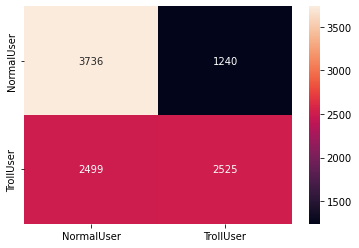

In [51]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['text', 'pos', 'hashtag', 'feats'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.626

## Only hashtags

LinearClassifier(
  (hashtag_embedder): EmbeddingBag(3934, 64, mode=mean)
  (hid_layer1): Linear(in_features=64, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.52819053	Train Acc: 0.73260156
  ...Batch 2000	Epoch 1	Loss: 0.51578509	Train Acc: 0.73747266
  ...Batch 3000	Epoch 1	Loss: 0.50794329	Train Acc: 0.74044792
  ...Batch 4000	Epoch 1	Loss: 0.50164648	Train Acc: 0.74333203
  ...Batch 5000	Epoch 1	Loss: 0.49716640	Train Acc: 0.74541094
  ...Batch 6000	Epoch 1	Loss: 0.49352797	Train Acc: 0.74714063
  ...Batch 7000	Epoch 1	Loss: 0.49082102	Train Acc: 0.74832143



              precision

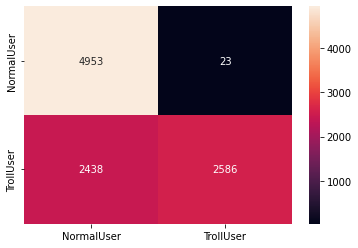

In [52]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['text', 'pos', 'ent', 'feats'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.7538

## Only Feats

LinearClassifier(
  (feat_transform): Linear(in_features=4, out_features=4, bias=True)
  (hid_layer1): Linear(in_features=4, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.64564737	Train Acc: 0.61322656
  ...Batch 2000	Epoch 1	Loss: 0.63283508	Train Acc: 0.62180078
  ...Batch 3000	Epoch 1	Loss: 0.62545504	Train Acc: 0.62751563
  ...Batch 4000	Epoch 1	Loss: 0.62011502	Train Acc: 0.63202148
  ...Batch 5000	Epoch 1	Loss: 0.61649673	Train Acc: 0.63456875
  ...Batch 6000	Epoch 1	Loss: 0.61367899	Train Acc: 0.63673568
  ...Batch 7000	Epoch 1	Loss: 0.61103166	Train Acc: 0.63910156



           

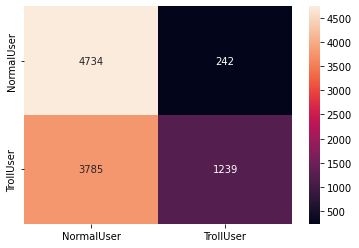

In [50]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['text', 'pos', 'ent', 'hashtag'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.597

## Only Text, POS

LinearClassifier(
  (text_embedder): EmbeddingBag(47879, 128, mode=mean)
  (pos_embedder): EmbeddingBag(52, 8, mode=mean)
  (hid_layer1): Linear(in_features=136, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.25552826	Train Acc: 0.89016406
  ...Batch 2000	Epoch 1	Loss: 0.20237453	Train Acc: 0.91394922
  ...Batch 3000	Epoch 1	Loss: 0.17761283	Train Acc: 0.92475521
  ...Batch 4000	Epoch 1	Loss: 0.16189460	Train Acc: 0.93146484
  ...Batch 5000	Epoch 1	Loss: 0.15104421	Train Acc: 0.93610469
  ...Batch 6000	Epoch 1	Loss: 0.14293279	Train Acc: 0.93958203
  ...Batch 7000	Epoch 1	Loss: 0.13643474

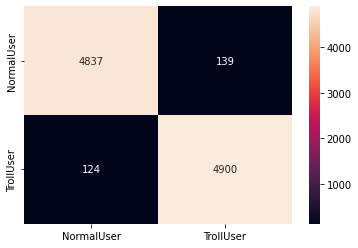

In [61]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['ent', 'hashtag', 'feats'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.9736

## Remove Text, POS

LinearClassifier(
  (ent_embedder): EmbeddingBag(19, 8, mode=mean)
  (hashtag_embedder): EmbeddingBag(3934, 64, mode=mean)
  (feat_transform): Linear(in_features=4, out_features=4, bias=True)
  (hid_layer1): Linear(in_features=76, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.48023061	Train Acc: 0.76712500
  ...Batch 2000	Epoch 1	Loss: 0.45236562	Train Acc: 0.78526562
  ...Batch 3000	Epoch 1	Loss: 0.43893013	Train Acc: 0.79336719
  ...Batch 4000	Epoch 1	Loss: 0.42914052	Train Acc: 0.79914258
  ...Batch 5000	Epoch 1	Loss: 0.42247425	Train Acc: 0.80290156
  ...Batch 6000	Epoch 1	Loss: 0.41

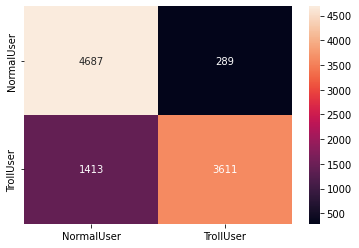

In [57]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['text', 'pos'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.8298

## Remove Text, POS, Feats

LinearClassifier(
  (ent_embedder): EmbeddingBag(19, 8, mode=mean)
  (hashtag_embedder): EmbeddingBag(3934, 64, mode=mean)
  (hid_layer1): Linear(in_features=72, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.51983006	Train Acc: 0.73408594
  ...Batch 2000	Epoch 1	Loss: 0.50564792	Train Acc: 0.74123438
  ...Batch 3000	Epoch 1	Loss: 0.49687746	Train Acc: 0.74529948
  ...Batch 4000	Epoch 1	Loss: 0.48963211	Train Acc: 0.74930664
  ...Batch 5000	Epoch 1	Loss: 0.48448050	Train Acc: 0.75209063
  ...Batch 6000	Epoch 1	Loss: 0.48026360	Train Acc: 0.75439714
  ...Batch 7000	Epoch 1	Loss: 0.47712066

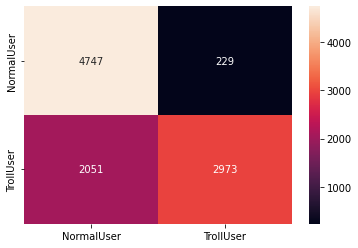

In [58]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['text', 'pos', 'feats'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.7720

## Only POS, Entities

LinearClassifier(
  (pos_embedder): EmbeddingBag(52, 8, mode=mean)
  (ent_embedder): EmbeddingBag(19, 8, mode=mean)
  (hid_layer1): Linear(in_features=16, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
  ...Batch 1000	Epoch 1	Loss: 0.40979278	Train Acc: 0.80673438
  ...Batch 2000	Epoch 1	Loss: 0.32805476	Train Acc: 0.85028516
  ...Batch 3000	Epoch 1	Loss: 0.28893320	Train Acc: 0.86995312
  ...Batch 4000	Epoch 1	Loss: 0.26427855	Train Acc: 0.88215430
  ...Batch 5000	Epoch 1	Loss: 0.24786205	Train Acc: 0.89013906
  ...Batch 6000	Epoch 1	Loss: 0.23538511	Train Acc: 0.89607812
  ...Batch 7000	Epoch 1	Loss: 0.22570691	Train 

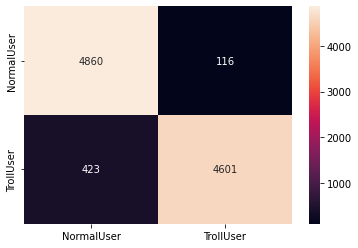

In [48]:
model_name, lin_model_ablation, losses = run_ablation_study(
    ['text', 'hashtag', 'feats'], w2v_token_128_model, x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin)
#0.946

# Generate an Image of the Network (optional)

In [ ]:
from torchviz import make_dot
#you need to explicitly set the path for this lib
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

In [ ]:
lin_model = LinearClassifier(hid1_size=512, hid2_size=128, out_size=2, 
                             text_vocab_size=len(word2idx), text_emb_dim=word_vec_dim, 
                             pos_vocab_size=len(pos2idx), pos_emb_dim=8,
                             ent_vocab_size=len(ent2idx), ent_emb_dim=8, 
                             hashtag_vocab_size=len(hashtag2idx), hashtag_emb_dim=64, 
                             in_feat_dim=len(feat_fields), out_feat_dim=len(feat_fields))

lin_model.load_state_dict(torch.load("lin_model_bin.pt"))
lin_model.eval()

In [ ]:
out = lin_model(x_text[:10], x_pos[:10], x_ent[:10], x_hashtag[:10], x_feats[:10])

In [ ]:
make_dot(out, params=dict(list(lin_model.named_parameters()))).render("linear_model", format="jpg")